# All the needed functions for the error analysis

In [27]:
import json

def find_wrong_predictions(file_name):
    with open(file_name) as file:
        lines = file.read().splitlines()

    wrong_predictions = [json.loads(s) for s in lines if json.loads(s)['true_label'] != json.loads(s)['predicted_label']]
    count_general=len(lines)
    print("General number of all sentences:",count_general)
    count_errors=len(wrong_predictions)
    print("Number of wrongly predicted sentences:",count_errors)
    return wrong_predictions,lines

In [28]:
def count_false_positives_and_negatives(data):
    """
    Count false positives (FP) and false negatives (FN) from a list of dictionaries.
    
    Returns:
    fp_count (int): Number of false positives.
    fn_count (int): Number of false negatives.
    """
    fp_count = []
    fn_count = []
    
    for example in data:
        true_label = int(example['true_label'])
        predicted_label = int(example['predicted_label'])
        
        if true_label == 1 and predicted_label == 0:
            fn_count.append(example)
        elif true_label == 0 and predicted_label == 1:
            fp_count.append(example)
    fp_percent=round((len(fp_count)/len(data))*100)
    fn_percent=round((len(fn_count)/len(data))*100)
    print("The number of fasle positives:",len(fn_count),",and percentage of it:",fp_percent,"%")
    print("The number of false negatives:",len(fp_count),",and percentage of it:",fn_percent,"%")
    return fp_count, fn_count

In [29]:
from nltk.corpus import stopwords
import re
sw = stopwords.words('english')
def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + ',_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [30]:
import nltk
from collections import Counter

def get_top_words(sentences, num_words=20):
    # Tokenize the sentences into words
    words = nltk.word_tokenize(" ".join(sentences))

    # Count the frequency of each word
    word_freq = Counter(words)

    # Sort the words by frequency in descending order
    sorted_word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))

    # Get the top N most frequent words
    top_words = dict(list(sorted_word_freq.items())[:num_words])

    return top_words

def plot_top_words(sentences, title="Top 20 Most Frequent Words", num_words=20):
    # Get the top N most frequent words
    top_words = get_top_words(sentences, num_words)

    # Extract the words and their frequencies
    words = list(top_words.keys())
    frequencies = list(top_words.values())

    # Create a bar chart
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(words)), frequencies, tick_label=words)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent words at the top
    plt.show()

In [31]:
import json
from transformers import AutoTokenizer
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
    
def cleaned_sentences(file_path):
    """
    Tokenize sentences from a file and return tokenized features.

    Args:
    file_path (str): Path to the file containing sentences.
    model_name (str): Name of the pretrained model to use (e.g., 'xlm-roberta-base').
    max_length (int): Maximum length for tokenized sequences.

    Returns:
    tokenized_features (dict): Tokenized features including input IDs, attention masks, etc.
    """

    # Read sentences from the file and apply clean_text function
    sentences = []
    with open(file_path) as file:
        baseline_all_predictions = file.read().splitlines()
    for item in baseline_all_predictions:
        cleaned_sentence = clean_text(json.loads(item)['sentence'])  # You need to define the clean_text function
        sentences.append(cleaned_sentence)
        
    return sentences

# The error analysis of the baseline model : trained and tested on Manifesto

# Error №1 of the baseline: repeated sentences with different labels

In [32]:
import numpy as np
import pandas as pd
f = open('/data/data_codebook.json')
data_codebook = json.load(f)
super_set={}
for s in data_codebook:
    if s[2]!="domain_name":
        if s[2] not in super_set:
            super_set[s[2]]=[]
        if s[5] not in super_set[s[2]]:
            super_set[s[2]].append(s[5])
with open('test_dataset.json', 'r') as fp:
    test_dataset = json.load(fp)
test_dataframe=[]
for k,v in test_dataset.items():
    for key, value in super_set.items():
        if k in value:
            super_label = key
    for s in v:
            per_line_dict = {}
            per_line_dict["sentence"] = s
            per_line_dict["detailed_label"] = k
            per_line_dict["general_label"] = super_label
            test_dataframe.append(per_line_dict)

In [33]:
def find_repeated_sentences(data_frame):
    sentence_counts = {}
    
    # Count the occurrences of each sentence
    for item in data_frame:
        sentence = item['sentence']
        if sentence not in sentence_counts:
            sentence_counts[sentence] = 0
        sentence_counts[sentence] += 1
    
    repeated_sentences = [sentence for sentence, count in sentence_counts.items() if count > 1]
    print("The number of repeated sentences:", len(repeated_sentences))
    
    repeated_sentence_items = {}
    
    # Collect items with repeated sentences
    for item in data_frame:
        sentence = item['sentence']
        if sentence in repeated_sentences:
            if sentence not in repeated_sentence_items:
                repeated_sentence_items[sentence] = []
            repeated_sentence_items[sentence].append(item)
    
    return repeated_sentence_items

# Usage example:
# Assuming you have a 'test_dataframe' with the same structure as before
check_repeated_sentences = find_repeated_sentences(test_dataframe)

The number of repeated sentences: 209


In [34]:
def categorize_repeated_sentences(repeated_sentences_data):
    identical = []
    same_domain = []
    same_category = []
    everything_different = []

    for k, v in repeated_sentences_data.items():
        domains = {item['general_label'] for item in v}
        categories = {item['detailed_label'] for item in v}
        domains_categories = {f"{item['general_label']}{item['detailed_label']}" for item in v}

        if len(domains) == len(categories) == len(domains_categories) == 1:
            identical.append(v)
        elif len(domains) > 1 and len(categories) == 1:
            same_category.append(v)
        elif len(categories) > 1 and len(domains) == 1:
            same_domain.append(v)
        elif len(domains_categories) > 1:
            everything_different.append(v)

    identical_count = len(identical)
    same_domain_count = len(same_domain)
    same_category_count = len(same_category)
    everything_different_count = len(everything_different)

    result = {
        "identical_count": identical_count,
        "same_domain_count": same_domain_count,
        "same_category_count": same_category_count,
        "everything_different_count": everything_different_count
    }

    
    return result,same_domain,everything_different

# Usage example:
# Assuming you have 'repeated_sentences_data' from the previous function call
result,same_domain,everything_different = categorize_repeated_sentences(check_repeated_sentences)

# Printing the counts
print(f"Number of sets with identical domains, categories, and domain+category combinations: {result['identical_count']}")
print(f"Number of sets with the same domain but differing categories: {result['same_domain_count']}")
print(f"Number of sets with the same category but differing domains: {result['same_category_count']}")
print(f"Number of sets with both different domains and categories: {result['everything_different_count']}")


Number of sets with identical domains, categories, and domain+category combinations: 159
Number of sets with the same domain but differing categories: 15
Number of sets with the same category but differing domains: 0
Number of sets with both different domains and categories: 35


In [35]:
from collections import Counter
length=[]
for k,v in check_repeated_sentences.items():
    length.append(len(v))
print(Counter(length))

Counter({2: 206, 3: 3})


In [36]:
print("Set with the same domain but differing categories")
for item in same_domain:
    print("----------------------")
    print(item)

Set with the same domain but differing categories
----------------------
[{'sentence': ' Hospitals', 'detailed_label': 'Welfare State Expansion', 'general_label': 'Welfare and Quality of Life'}, {'sentence': ' Hospitals', 'detailed_label': 'Equality: Positive', 'general_label': 'Welfare and Quality of Life'}]
----------------------
[{'sentence': ' self employment', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}, {'sentence': ' self employment', 'detailed_label': 'Underprivileged Minority Groups', 'general_label': 'Social Groups'}]
----------------------
[{'sentence': ' Agriculture', 'detailed_label': 'Incentives: Positive', 'general_label': 'Economy'}, {'sentence': ' Agriculture', 'detailed_label': 'Protectionism: Negative', 'general_label': 'Economy'}]
----------------------
[{'sentence': nan, 'detailed_label': 'Incentives: Positive', 'general_label': 'Economy'}, {'sentence': nan, 'detailed_label': 'Technology and Infrastructure: Positive', 'g

In [37]:
print("Set with both different domains and categories")
for item in everything_different:
    print("----------------------")
    print(item)

Set with both different domains and categories
----------------------
[{'sentence': ' Organization', 'detailed_label': 'Welfare State Expansion', 'general_label': 'Welfare and Quality of Life'}, {'sentence': ' Organization', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}]
----------------------
[{'sentence': ' culture and media', 'detailed_label': 'Welfare State Expansion', 'general_label': 'Welfare and Quality of Life'}, {'sentence': ' culture and media', 'detailed_label': 'Law and Order: Positive', 'general_label': 'Fabric of Society'}]
----------------------
[{'sentence': ' security,', 'detailed_label': 'Welfare State Expansion', 'general_label': 'Welfare and Quality of Life'}, {'sentence': ' security,', 'detailed_label': 'Military: Positive', 'general_label': 'External Relations'}, {'sentence': ' security,', 'detailed_label': 'Law and Order: Positive', 'general_label': 'Fabric of Society'}]
----------------------
[{'sentence': ' Deadline: 2

Let's track the source of the duplication issue: is it the dataset problem or the translation issue?

In [38]:
f = open('/data/metadata.json')
metadata = json.load(f)
a = open('/data/annotations.json')
annotations = json.load(a)
import json
f = open('/data/data_codebook.json')
data_codebook = json.load(f)
#combine 
dataset={}
for s in metadata:
    if s['items'][0]['annotations']==None:
        pass
    else:
        if s['items'][0]['annotations']!=False:
            s=s['items'][0]
            for text in annotations:
                text=text['items'][0]
                if s['manifesto_id']==text['key']:
                    if s['manifesto_id'] not in dataset:
                        dataset[s['manifesto_id']]={}
                    dataset[s['manifesto_id']]["metadata"]=s
                    dataset[s['manifesto_id']]["annotation"]=text
#create dataset
data_codebook_dict={}
for s in data_codebook:
    data_codebook_dict[s[3]]=s[5]
dataset_right={}
for k,v in dataset.items():
    main_annotation={}
    main_annotation['key']= v['annotation']['key']
    if "sentences" not in main_annotation:
        main_annotation["sentences"]={}
    for s in v['annotation']["items"]:
        if s['cmp_code'] in data_codebook_dict:
            name=data_codebook_dict[s['cmp_code']]
        main_annotation["sentences"][s['text']]=name
    if k not in dataset_right:
        dataset_right[k]={}
    dataset_right[k]['metadata']=v['metadata']
    dataset_right[k]['annotation']=main_annotation

In [39]:
count_corpus_sentences={}
general_number_annotated=0
for k,v in dataset_right.items():
    annotated=v['annotation']['sentences']
    for sentence,annotation in annotated.items():
        #print(sentence,annotation)
        general_number_annotated+=1
        if sentence not in count_corpus_sentences:
            count_corpus_sentences[sentence]=0
        count_corpus_sentences[sentence]+=1
        
        
track_corpus_repeated={}
repeated_corpus_sentences=set()
for k,v in count_corpus_sentences.items():
    if v>1:
        repeated_corpus_sentences.add(k)
        
        
for k,v in dataset_right.items():
    annotated=v['annotation']['sentences']
    for sentence,annotation in annotated.items():
        if sentence in repeated_corpus_sentences:
            if sentence not in track_corpus_repeated:
                track_corpus_repeated[sentence]=[]
            track_corpus_repeated[sentence].append(annotation)
print("How many repetitions in the corpus?",len(track_corpus_repeated))
corpus_identical=0
corpus_different={}
for k,v in track_corpus_repeated.items():
    if len(set(v))==1:
        corpus_identical+=1
    else:
        corpus_different[k]=set(v)
print("The number of identical duplications:",corpus_identical)
print("The number of non-identical duplications:",int(len(track_corpus_repeated)-corpus_identical))

How many repetitions in the corpus? 63821
The number of identical duplications: 50507
The number of non-identical duplications: 13314


In [40]:
for k,v in corpus_different.items():
    if len(v)==22:
        print(k,len(v))

Transport 22


In [41]:
count_repetititons_numbers={}
for k,v in corpus_different.items():
    if len(v) not in count_repetititons_numbers:
        count_repetititons_numbers[len(v)]=0
    count_repetititons_numbers[len(v)]+=1
count_repetititons_numbers={k: v for k, v in sorted(count_repetititons_numbers.items(), key=lambda item: item[0])}
count_repetititons_numbers

{2: 12043,
 3: 812,
 4: 203,
 5: 110,
 6: 48,
 7: 36,
 8: 9,
 9: 17,
 10: 8,
 11: 8,
 12: 6,
 13: 2,
 14: 3,
 15: 2,
 16: 2,
 17: 2,
 20: 1,
 22: 1,
 24: 1}

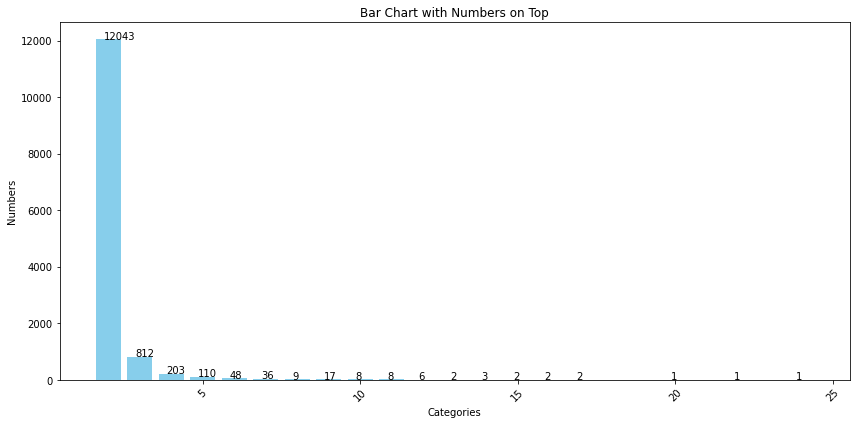

In [42]:
import matplotlib.pyplot as plt

categories = list(count_repetititons_numbers.keys())
numbers = list(count_repetititons_numbers.values())

# Increase the figure size to fit the data
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

bars = plt.bar(categories, numbers, color='skyblue')

for bar, number in zip(bars, numbers):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 10, str(number), fontsize=10)

plt.xlabel('Categories')
plt.ylabel('Numbers')
plt.title('Bar Chart with Numbers on Top')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()


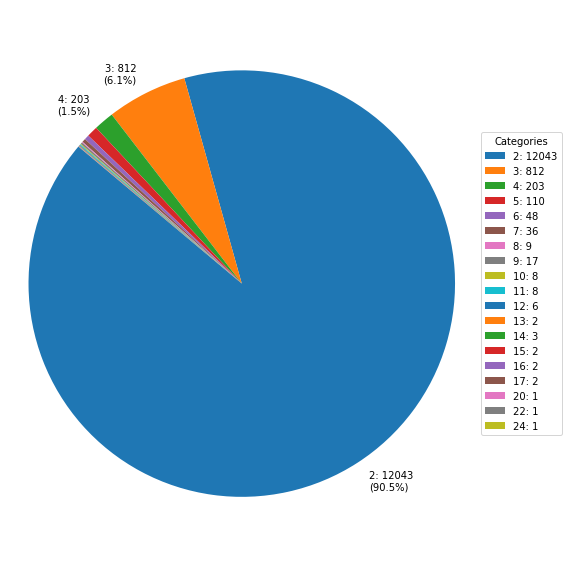

In [43]:
categories = list(count_repetititons_numbers.keys())
numbers = list(count_repetititons_numbers.values())
# Filter categories to show percentage labels
categories_to_label = [2, 3, 4]
filtered_categories = [category if category in categories_to_label else None for category in categories]
filtered_labels = [f"{category}: {numbers[i]}\n({numbers[i] / sum(numbers) * 100:.1f}%)"
                   if category in categories_to_label else ''
                   for i, category in enumerate(categories)]

# Create a slightly larger pie chart
plt.figure(figsize=(8, 8))  # Adjust the figure size to make the pie chart slightly larger
plt.pie(numbers, labels=filtered_labels, autopct='', startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Keep the legend the same size
legend_labels = [f"{category}: {number}" for category, number in zip(categories, numbers)]
plt.legend(legend_labels, title="Categories", loc="center left", bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()

In [44]:
from nltk.tokenize import wordpunct_tokenize
get_the_longest_duplicated_sentence={}
n=[]
for k,v in corpus_different.items():
    if len(v)==22:
        print("...........................................")
        print("The sentence which was labelled 22 times differently:")
        print(k,v)
        print("...........................................''")
    tokenized_sentence=wordpunct_tokenize(k)
    get_the_longest_duplicated_sentence[k]=(len(tokenized_sentence),len(v),v)
    n.append(len(tokenized_sentence))
max_length=max(n)
print("The duplicated sentence with maximum number of words and the number of words there:",max_length)

for k,v in get_the_longest_duplicated_sentence.items():
    if v[0]==128:
        print("The sentence:",k)
        longest_sentence=k
        print("How many times it was repeated:", v[1],"the labels are:",v[2])

...........................................
The sentence which was labelled 22 times differently:
Transport {'Agriculture and Farmers: Positive', 'National Way of Life: Immigration: Positive', 'Anti-Growth Economy: Positive', 'Incentives: Positive', 'Underprivileged Minority Groups', 'Multiculturalism General: Positive', 'Protectionism: Positive', 'Sustainability: Positive', 'Market Regulation', 'Free Market Economy', 'Technology and Infrastructure: Positive', 'No other category applies', 'Welfare State Expansion', 'Environmental Protection', 'Equality: Positive', 'National Way of Life General: Positive', 'Economic Planning', 'Culture: Positive', 'Protectionism: Negative', 'Decentralization', 'Controlled Economy', 'Political Authority'}
...........................................''
The duplicated sentence with maximum number of words and the number of words there: 128
The sentence: La Constitución del 78 recoge derechos como: el derecho a un trabajo suficientemente remunerado (art. 35)

In [45]:
for k,v in dataset_right.items():
    annotated=v['annotation']['sentences']
    for sentence,annotation in annotated.items():
        if sentence==longest_sentence:
            print("----------")
            print(sentence)
            print(v['metadata'])
            print(annotation)

----------
La Constitución del 78 recoge derechos como: el derecho a un trabajo suficientemente remunerado (art. 35), el derecho al acceso a la cultura (art. 44), derecho a una vivienda digna y adecuada (art. 47) y que los poderes públicos “establecerán los medios que faciliten el acceso de los trabajadores a la propiedad de los medios de producción” (art. 129) y que “el Estado, mediante Ley, podrá planificar la actividad económica general para atender a las necesidades colectivas, equilibrar y armonizar el desarrollo regional y sectorial y estimular el crecimiento de la renta y de la riqueza y su más justa distribución” (art. 131.1).
{'party_id': 33220, 'election_date': '201111', 'language': 'spanish', 'source': 'MARPOR', 'has_eu_code': False, 'is_primary_doc': True, 'may_contradict_core_dataset': False, 'manifesto_id': '33220_201111', 'md5sum_text': '62dace52d6cc03403ca68a7852806cbf', 'url_original': '/down/originals/33220_2011.pdf', 'md5sum_original': '48af4e2a6ca71ab4d9bdc50163cea0

TRAIN DATASET

In [21]:
with open('train_dataset.json', 'r') as fp:
    train_dataset = json.load(fp)
def calculate_dataset_counts(dataset):
    count_dataset = {
        "general": {},
        "detailed": {}
    }
    
    for s in dataset:
        detailed_label = s['detailed_label']
        general_label = s["general_label"]
        
        if detailed_label not in count_dataset["detailed"]:
            count_dataset["detailed"][detailed_label] = 0
        count_dataset["detailed"][detailed_label] += 1

        if general_label not in count_dataset["general"]:
            count_dataset["general"][general_label] = 0
        count_dataset["general"][general_label] += 1
    
    return count_dataset  
    
def create_custom_dataset(balanced_dataset, total_limit, desired_percentage):
    used_sentences = set()
    dataset = []
    welfare_count = 0
    welfare_limit = int(total_limit * desired_percentage)
    category_limits = {category: 100 for category in balanced_dataset.keys()}

    # Calculate the total number of sentences in the dataset
    total_sentences = sum(len(v) for v in balanced_dataset.values())

    # First, add sentences from 'Environmental Protection'
    for sentence in balanced_dataset['Environmental Protection']:
        if len(dataset) >= welfare_limit:
            break

        if sentence not in used_sentences:
            per_line_dict = {
                "sentence": sentence,
                "detailed_label": 'Environmental Protection',
                "general_label": 'Welfare and Quality of Life'
            }
            dataset.append(per_line_dict)
            used_sentences.add(sentence)
            welfare_count += 1

    # Then, add sentences from other categories
    while len(dataset) < total_limit:
        for category, sentences in balanced_dataset.items():
            if len(dataset) >= total_limit:
                break
            if category != 'Environmental Protection':
                for key, value in super_set.items():
                    if category in value:
                        super_label = key

                category_limit = min(len(sentences), category_limits[category])

                limit = min(100, category_limit)

                for sentence in sentences:
                    if limit == 0 or len(dataset) >= total_limit:
                        break

                    if sentence not in used_sentences:
                        per_line_dict = {
                            "sentence": sentence,
                            "detailed_label": category,
                            "general_label": super_label
                        }
                        dataset.append(per_line_dict)
                        used_sentences.add(sentence)
                        limit -= 1
                        category_limits[category] += 100

    return dataset, welfare_count

"Experiment 1"
total_limit = 56000
desired_percentage = 0.10

dataset, welfare_count = create_custom_dataset(train_dataset, total_limit, desired_percentage)

print("Total sentences in the dataset:", len(dataset))
print("Sentences with 'Environmental Protection' label:", welfare_count)

# Usage example:
# Assuming you have the 'dataset' variable containing the dataset obtained from the create_custom_dataset function
# Replace this with the actual dataset you want to count.
count_dataset = calculate_dataset_counts(dataset)
print(count_dataset["general"])

Total sentences in the dataset: 56000
Sentences with 'Environmental Protection' label: 5600
{'Welfare and Quality of Life': 9826, 'Economy': 11514, 'Fabric of Society': 13523, 'Social Groups': 3173, 'External Relations': 6903, 'Freedom and Democracy': 5980, 'Political System': 5081}


In [30]:
print("Check Train set for duplication error:")
find_repeated_sentences(dataset)

Check Train set for duplication error:
The number of repeated sentences: 0


{}

In [25]:
"-----------------------------------------Test dataset--------------------------------------------------------------"

'-----------------------------------------Test dataset--------------------------------------------------------------'

In [62]:
errors_baseline,original_baseline= find_wrong_predictions("baseline_predictions.txt")

baseline_errors = [item['sentence'] for item in errors_baseline]
baseline_tokenized = [wordpunct_tokenize(sentence) for sentence in baseline_errors]

General number of all sentences: 84860
Number of wrongly predicted sentences: 5586


max:  131
min:  1


(array([   0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500')])

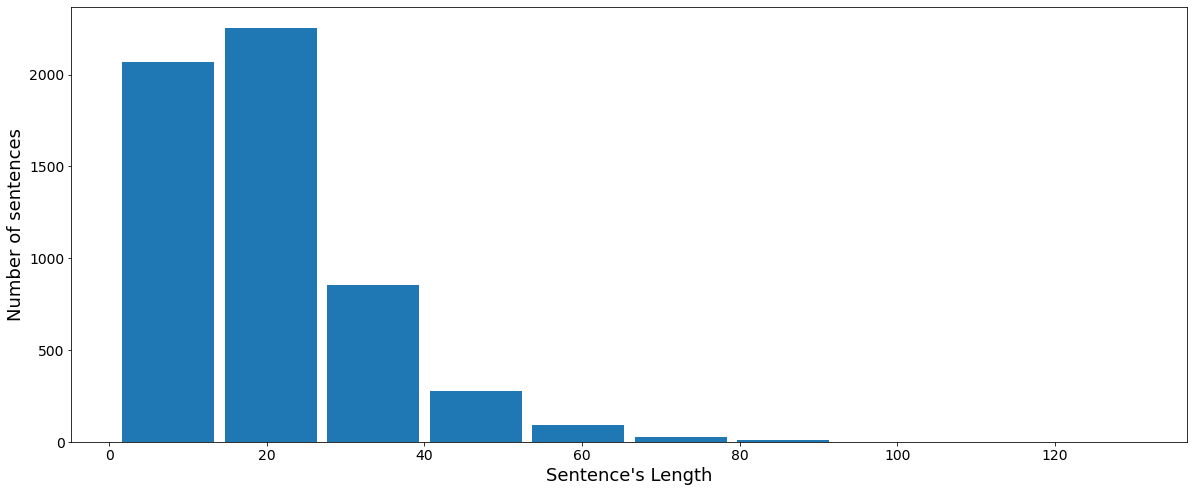

In [63]:
# collect tokenized sentence length 
token_sentence_length = [len(x) for x in baseline_tokenized]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
MAX_LEN = max(token_sentence_length)
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel("Sentence's Length", fontsize = 18)
plt.ylabel('Number of sentences', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [64]:
baseline_fp,baseline_fn=count_false_positives_and_negatives(errors_baseline)

The number of fasle positives: 2154 ,and percentage of it: 61 %
The number of false negatives: 3432 ,and percentage of it: 39 %


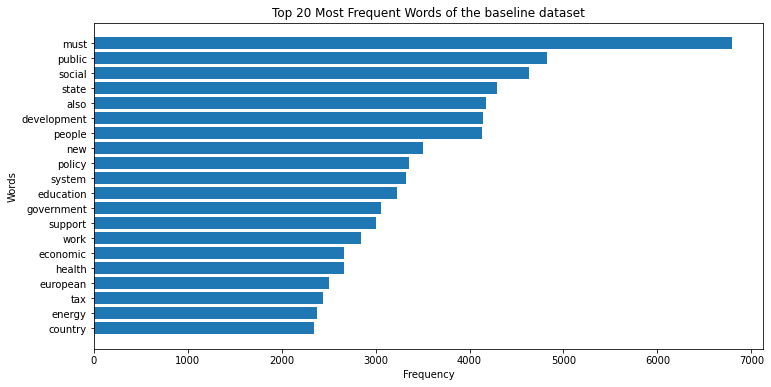

In [65]:
# Sample list of sentences
baseline_cleaned_sentences = cleaned_sentences("baseline_predictions.txt")

# Plot the top 20 most frequent words
plot_top_words(baseline_cleaned_sentences, title="Top 20 Most Frequent Words of the baseline dataset")

In [66]:
repetitions_test=set()
for item in everything_different:
    for s in item:
        repetitions_test.add(s['sentence'])
for item in same_domain:
    for s in item:
        repetitions_test.add(s['sentence'])

In [67]:
c=0
for item in errors_baseline:
    if item['sentence'] in repetitions_test:
        print(item)

{'sentence': ' natural resources,', 'true_label': '0', 'predicted_label': '1'}
{'sentence': ' AIR TRAFFIC', 'true_label': '0', 'predicted_label': '1'}
{'sentence': ' DEADLINE: 2017-2020', 'true_label': '1', 'predicted_label': '0'}
{'sentence': ' The protection of road users, whether motorists, cyclists or pedestrians, must be considered a priority.', 'true_label': '0', 'predicted_label': '1'}
{'sentence': ' Preface', 'true_label': '1', 'predicted_label': '0'}
{'sentence': ' energy', 'true_label': '1', 'predicted_label': '0'}
{'sentence': ' and health', 'true_label': '1', 'predicted_label': '0'}
{'sentence': ' Environmental Protection', 'true_label': '0', 'predicted_label': '1'}
{'sentence': ' The protection of road users, whether motorists, cyclists or pedestrians, must be considered a priority.', 'true_label': '0', 'predicted_label': '1'}
{'sentence': ' energy', 'true_label': '1', 'predicted_label': '0'}
{'sentence': ' Justice', 'true_label': '1', 'predicted_label': '0'}
{'sentence': 

In [68]:
for item in baseline_fp:
    for i in test_dataframe:
        if item['sentence']==i['sentence']:
            print("-------")
            print(i)
            print(item)

-------
{'sentence': ' The Republic of Moldova needs to increase the production of vegetables outside the hot season, and the development of greenhouses is essential.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' The Republic of Moldova needs to increase the production of vegetables outside the hot season, and the development of greenhouses is essential.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' The GREENS are well represented in the cities and agglomerations.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' The GREENS are well represented in the cities and agglomerations.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' natural resources,', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' natural resources,', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' natural

-------
{'sentence': ' We intend to promote investments in the extraction of minerals not yet used - anhydrite, sapropel and others.', 'detailed_label': 'Economic Growth: Positive', 'general_label': 'Economy'}
{'sentence': ' We intend to promote investments in the extraction of minerals not yet used - anhydrite, sapropel and others.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': " or the state's conservation policy,", 'detailed_label': 'Market Regulation', 'general_label': 'Economy'}
{'sentence': " or the state's conservation policy,", 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' //5. To promote the design of products that are friendly (or friendlier) to the environment, with the use of appropriate technology and the parallel creation of reception areas for processing and recycling or energy recovery from waste and other materials that are discarded after the first use.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{

-------
{'sentence': ' They interact with the Ministry of the Environment on which national planning depends and with the Regions and Municipalities.', 'detailed_label': 'Decentralization', 'general_label': 'Political System'}
{'sentence': ' They interact with the Ministry of the Environment on which national planning depends and with the Regions and Municipalities.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Increase the share of organic agriculture.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' Increase the share of organic agriculture.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' and draw up a plan to break away from oil dependence.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' and draw up a plan to break away from oil dependence.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'The construction of a 

-------
{'sentence': ' In the plans prepared while creating new living spaces, design principles will be determined by considering the geography, climate, historical background and topography of the city.', 'detailed_label': 'Economic Planning', 'general_label': 'Economy'}
{'sentence': ' In the plans prepared while creating new living spaces, design principles will be determined by considering the geography, climate, historical background and topography of the city.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'Since the energy density of biofuels is relatively low, they should not be transported over long distances.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': 'Since the energy density of biofuels is relatively low, they should not be transported over long distances.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Høyre believes that investment in new renewable energy sources should be 

-------
{'sentence': ' New raw materials for agriculture (compost, soil improver, fertilizers) can be produced from the digestate. (V)', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' New raw materials for agriculture (compost, soil improver, fertilizers) can be produced from the digestate. (V)', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Holder: NU Conservation Center - Skopje.', 'detailed_label': 'Culture: Positive', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Holder: NU Conservation Center - Skopje.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Water treatment station in the village of Dolno Kosovrasti', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' Water treatment station in the village of Dolno Kosovrasti', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' The labeling procedure for foods made from genet

-------
{'sentence': ' Creating income protection & security from damage by protecting production from the risks of climate change.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' Creating income protection & security from damage by protecting production from the risks of climate change.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' The use of pesticides is also not subsidized in Switzerland.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' The use of pesticides is also not subsidized in Switzerland.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' - Regarding water resources:', 'detailed_label': 'Decentralization', 'general_label': 'Political System'}
{'sentence': ' - Regarding water resources:', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' The NDP is committed to replacing the current public lighting system with a new system

-------
{'sentence': ' More nature helps to combat climate change, but also to absorb the effects of climate change.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' More nature helps to combat climate change, but also to absorb the effects of climate change.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Environmentalists want to reverse the current logic.', 'detailed_label': 'Anti-Growth Economy: Positive', 'general_label': 'Economy'}
{'sentence': ' Environmentalists want to reverse the current logic.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' The judiciary shows a great lack of willingness to impose adequate punishments where animal abuse is concerned.', 'detailed_label': 'Law and Order: Positive', 'general_label': 'Fabric of Society'}
{'sentence': ' The judiciary shows a great lack of willingness to impose adequate punishments where animal abuse is concerned.', 'true_label': '0', 'predicted_labe

-------
{'sentence': ' ▪bring in the National Spatial Development Plan and the necessary strategies for the transition to green spatial planning and urban planning in accordance with the requirements of sustainability and climate neutrality', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' ▪bring in the National Spatial Development Plan and the necessary strategies for the transition to green spatial planning and urban planning in accordance with the requirements of sustainability and climate neutrality', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' In most arid regions, access to clean drinking water is becoming more difficult.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' In most arid regions, access to clean drinking water is becoming more difficult.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' At Alternativet, we do not believe that environmental and cli

{'sentence': ' The realization will take place through the stations, the ambulances and the Veterinary Institute.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' The realization will take place through the stations, the ambulances and the Veterinary Institute.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' In accordance with world and European standards, work on the construction of wind farms and sources of solar energy, and sources of geothermal energy', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' In accordance with world and European standards, work on the construction of wind farms and sources of solar energy, and sources of geothermal energy', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' We will support the facilities for processing organic livestock and their products in our regions with livestock potential and clean environment.', 'detai

-------
{'sentence': 'The renewable electricity must be used where it can replace fossil energy use, such as in the transport sector and through more electrification of the petroleum sector.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': 'The renewable electricity must be used where it can replace fossil energy use, such as in the transport sector and through more electrification of the petroleum sector.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'With high-quality, tailor-made public transport, we make commuting more environmentally friendly.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': 'With high-quality, tailor-made public transport, we make commuting more environmentally friendly.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' //Energy Saving Energy performance of buildings.', 'detailed_label': 'Sustainability: Positive', 'general_label': 

-------
{'sentence': ' The goal should be a balanced and ecologically sustainable development of the northern regions while utilizing the traffic routes and natural resources that open up.', 'detailed_label': 'Anti-Growth Economy: Positive', 'general_label': 'Economy'}
{'sentence': ' The goal should be a balanced and ecologically sustainable development of the northern regions while utilizing the traffic routes and natural resources that open up.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' built, movable, archaeological, documentary and inorganic heritage), in order to guarantee the exact knowledge of stocks and to stop the bleeding of prey and destruction in vast areas of the national fabric.', 'detailed_label': 'Culture: Positive', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' built, movable, archaeological, documentary and inorganic heritage), in order to guarantee the exact knowledge of stocks and to stop the bleeding of prey and destruction

-------
{'sentence': 'Transport is responsible for 24% of greenhouse gas emissions and 74% of oil consumption in Portugal, and is also one of the main sources of noise and air pollution, in particular emissions of nitrogen oxides and particles , cause of respiratory diseases and a large number of premature deaths.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': 'Transport is responsible for 24% of greenhouse gas emissions and 74% of oil consumption in Portugal, and is also one of the main sources of noise and air pollution, in particular emissions of nitrogen oxides and particles , cause of respiratory diseases and a large number of premature deaths.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Green! calls, however, for harmonization and for limiting the proliferation of detailed provisions.', 'detailed_label': 'Governmental and Administrative Efficiency', 'general_label': 'Political System'}
{'sentence': ' Green! calls, 

-------
{'sentence': ' allow commercial activities in protected areas as long as this does not exceed the conservation values', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' allow commercial activities in protected areas as long as this does not exceed the conservation values', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'The current state of conservation and exploitation must be redefined, taking advantage of R+D+I technologies and defining new management models in accordance with economic availabilities.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': 'The current state of conservation and exploitation must be redefined, taking advantage of R+D+I technologies and defining new management models in accordance with economic availabilities.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Therefore, we propose: to create an Institute of Environmental E

-------
{'sentence': ' Our coastal policy is based on three overarching measures:', 'detailed_label': 'Decentralization', 'general_label': 'Political System'}
{'sentence': ' Our coastal policy is based on three overarching measures:', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' We combine economic growth with lower emissions.', 'detailed_label': 'National Way of Life General: Positive', 'general_label': 'Fabric of Society'}
{'sentence': ' We combine economic growth with lower emissions.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' 3. Legal regulation of the sector of renewable energy and energy efficiency', 'detailed_label': 'Economic Growth: Positive', 'general_label': 'Economy'}
{'sentence': ' 3. Legal regulation of the sector of renewable energy and energy efficiency', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Increase support for long-term investments in forestry and forest roads.', 'detailed_label': 'Agriculture 

-------
{'sentence': ' III. GREEN ECONOMY AND GREEN CONSCIOUSNESS', 'detailed_label': 'Governmental and Administrative Efficiency', 'general_label': 'Political System'}
{'sentence': ' III. GREEN ECONOMY AND GREEN CONSCIOUSNESS', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' In order to increase traffic safety, the Government of VMRO-DPMNE plans to continuously carry out a systematic examination of all state roads for the purpose of early detection of potential landslides and their timely rehabilitation.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' In order to increase traffic safety, the Government of VMRO-DPMNE plans to continuously carry out a systematic examination of all state roads for the purpose of early detection of potential landslides and their timely rehabilitation.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Transport is not an issue that can be dealt with on its own: tr

-------
{'sentence': ' Energy policy, building insulation policy and mobility policy are all important for meeting the challenges of the environment and climate.', 'detailed_label': 'Centralisation', 'general_label': 'Political System'}
{'sentence': ' Energy policy, building insulation policy and mobility policy are all important for meeting the challenges of the environment and climate.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' The immediate phasing out of nuclear energy and its replacement by renewable energies such as solar energy', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' The immediate phasing out of nuclear energy and its replacement by renewable energies such as solar energy', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' the water supply,', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' the water supply,', 'true_label': '0', 'pred

-------
{'sentence': ' They should be encouraged to improve the energy quality of rented properties (see our priority 3).', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' They should be encouraged to improve the energy quality of rented properties (see our priority 3).', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' The Center Party will continue and expand the strategically important urban environment agreements and the reward scheme which stimulates the cities to shift transport from private cars to public transport, cycling and walking.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' The Center Party will continue and expand the strategically important urban environment agreements and the reward scheme which stimulates the cities to shift transport from private cars to public transport, cycling and walking.', 'true_label': '0', 'predicted_label': '1'

-------
{'sentence': 'Genetically modified organisms (GMOs) are a logical development of breeding.', 'detailed_label': 'Traditional Morality: Negative', 'general_label': 'Fabric of Society'}
{'sentence': 'Genetically modified organisms (GMOs) are a logical development of breeding.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' - stimulating and supporting local authorities with regard to measures to limit the accessibility of urban areas for cars and to offer adequate facilities for alternative modes of transport (bicycle, local public transport);', 'detailed_label': 'Decentralization', 'general_label': 'Political System'}
{'sentence': ' - stimulating and supporting local authorities with regard to measures to limit the accessibility of urban areas for cars and to offer adequate facilities for alternative modes of transport (bicycle, local public transport);', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' They directly increase the quality of li

-------
{'sentence': ' no to tax on the first car,', 'detailed_label': 'Free Market Economy', 'general_label': 'Economy'}
{'sentence': ' no to tax on the first car,', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'Start of procedures for the construction of three new dams - "Luda Yana", "Plovdivtsi" and "Neikovtsi" and for the rehabilitation of the "Studena" dam.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': 'Start of procedures for the construction of three new dams - "Luda Yana", "Plovdivtsi" and "Neikovtsi" and for the rehabilitation of the "Studena" dam.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Energy, raw materials and climate change are a global issue.', 'detailed_label': 'Internationalism: Positive', 'general_label': 'External Relations'}
{'sentence': ' Energy, raw materials and climate change are a global issue.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence':

-------
{'sentence': ' 11.3 Specific emission system for use', 'detailed_label': 'Economic Growth: Positive', 'general_label': 'Economy'}
{'sentence': ' 11.3 Specific emission system for use', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' between the increase in public transport fares and the increase in car traffic,', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' between the increase in public transport fares and the increase in car traffic,', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' • intensify the marking of the fairway along the coast, and realize the Stad ship tunnel to improve safety at sea.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' • intensify the marking of the fairway along the coast, and realize the Stad ship tunnel to improve safety at sea.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Ano

-------
{'sentence': ' • open for increased petroleum activity in Northern Norway, including the areas Nordland VI and VII, Troms II, Jan Mayen, Møreblokkene and Barents Sea North', 'detailed_label': 'Economic Growth: Positive', 'general_label': 'Economy'}
{'sentence': ' • open for increased petroleum activity in Northern Norway, including the areas Nordland VI and VII, Troms II, Jan Mayen, Møreblokkene and Barents Sea North', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' - Gradually redirect freight transport by road to rail and waterways.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' - Gradually redirect freight transport by road to rail and waterways.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' · Create an environmental penalty on the consumer products most harmful to the environment.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' · Crea

-------
{'sentence': 'The Regions must be entrusted with the task of drawing up the water protection plan and the faculty of regulating the choice of the management model of the integrated water service, exclusively among those possible for public law bodies', 'detailed_label': 'Decentralization', 'general_label': 'Political System'}
{'sentence': 'The Regions must be entrusted with the task of drawing up the water protection plan and the faculty of regulating the choice of the management model of the integrated water service, exclusively among those possible for public law bodies', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'Study the possibility of pursuing a proactive policy of sterilizing stray cats;', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': 'Study the possibility of pursuing a proactive policy of sterilizing stray cats;', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Green plants 

-------
{'sentence': 'The green strategy for climate protection and the reduction of greenhouse gas emissions contains a whole series of measures, including the green tax reform, which rewards energy saving and energy efficiency and massively supports renewable sources what are the sun, the wind, the wood and the biogas.', 'detailed_label': 'Anti-Growth Economy: Positive', 'general_label': 'Economy'}
{'sentence': 'The green strategy for climate protection and the reduction of greenhouse gas emissions contains a whole series of measures, including the green tax reform, which rewards energy saving and energy efficiency and massively supports renewable sources what are the sun, the wind, the wood and the biogas.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Accordingly, subsidies in the agricultural sector must be based on high ecological and animal rights standards.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence

{'sentence': ' creation of technical and other assumptions for the landing of airplanes at the Sarajevo airport in conditions of fog and low temperatures;', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Toxic and hazardous waste', 'detailed_label': 'Non-economic Demographic Groups', 'general_label': 'Social Groups'}
{'sentence': ' Toxic and hazardous waste', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' These investments for improvement and infrastructural settlement of the pastures will be another stimulus for the development of animal husbandry.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' These investments for improvement and infrastructural settlement of the pastures will be another stimulus for the development of animal husbandry.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Move towards a system based on environmental (or green) taxation, which penalizes pol

-------
{'sentence': ' Ambitious energy and climate policy', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' Ambitious energy and climate policy', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' The environment is a cross-border issue.', 'detailed_label': 'Internationalism: Positive', 'general_label': 'External Relations'}
{'sentence': ' The environment is a cross-border issue.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' • exploitation of organic and inorganic materials at sea and undersea.', 'detailed_label': 'Economic Goals', 'general_label': 'Economy'}
{'sentence': ' • exploitation of organic and inorganic materials at sea and undersea.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' In Germany, which has embarked on a “zero nuclear power” policy, renewable energy accounted for only 6% of its total electricity in 2000, but rapidly increased to 28.5% in the first half of this year, 

-------
{'sentence': ' Today, trucks cause twice as many fatalities as passenger cars.', 'detailed_label': 'Law and Order: Positive', 'general_label': 'Fabric of Society'}
{'sentence': ' Today, trucks cause twice as many fatalities as passenger cars.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' The increasing privatization of water supply and water-related services poses a threat to the basic need for access to water for the poor part of the population.', 'detailed_label': 'Nationalisation', 'general_label': 'Economy'}
{'sentence': ' The increasing privatization of water supply and water-related services poses a threat to the basic need for access to water for the poor part of the population.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'replacement, construction or expansion of the infrastructure for transfer or supply of mineral water to users, reservoirs, heat exchangers, equipment for operation and water intake,', 'detailed_label': 'Techn

-------
{'sentence': ' The positive impact of the new European environment can only take shape on the basis of actions, movements and initiatives with specific planning.', 'detailed_label': 'Cyprus Issue', 'general_label': 'Fabric of Society'}
{'sentence': ' The positive impact of the new European environment can only take shape on the basis of actions, movements and initiatives with specific planning.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': " We know that the transport sector is one of the largest sources of Denmark's total emissions of greenhouse gases.", 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': " We know that the transport sector is one of the largest sources of Denmark's total emissions of greenhouse gases.", 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' In addition, more priority should be given to checking those roads where driving speeds do not exceed 80 km/h.', 'detailed_label': 'Law and

-------
{'sentence': ' //3. The shift to sustainable transport and communication since in recent years, the transport sector has the most uncontrolled increase in greenhouse gas emissions.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' //3. The shift to sustainable transport and communication since in recent years, the transport sector has the most uncontrolled increase in greenhouse gas emissions.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': " We don't want artificial sugars in our diet.", 'detailed_label': 'Welfare State Expansion', 'general_label': 'Welfare and Quality of Life'}
{'sentence': " We don't want artificial sugars in our diet.", 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' >Realization of the water pipeline in Orizari (Lipkovo Municipality) in cooperation with the Austrian Development Agency;', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sen

-------
{'sentence': ' Drastically reduce the number of combustion vehicles circulating in cities', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' Drastically reduce the number of combustion vehicles circulating in cities', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' • set requirements for low and zero emission technology in all transport tenders where possible, in order to stimulate the most environmentally friendly solutions on the sections in question.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' • set requirements for low and zero emission technology in all transport tenders where possible, in order to stimulate the most environmentally friendly solutions on the sections in question.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' • Increase ecodesign, the use of recovered materials and the promotion of traceability of all t

{'sentence': ' -To generalize the “Sunday without my car” operation once a year to the whole territory.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Greener Denmark - more environmentally friendly energy', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' Greener Denmark - more environmentally friendly energy', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Particular attention should be paid to landfills, which are now degrading the soil, reducing the amount of arable land and are a potential source of infection', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' Particular attention should be paid to landfills, which are now degrading the soil, reducing the amount of arable land and are a potential source of infection', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' the green economy serving sustainable development,', 'detailed_labe

-------
{'sentence': ' Reengineering public procurement to become a development tool and key driver of green growth.', 'detailed_label': 'Governmental and Administrative Efficiency', 'general_label': 'Political System'}
{'sentence': ' Reengineering public procurement to become a development tool and key driver of green growth.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' In the period 2021-2050, the average annual rate of change in thermal consumption is expected at -4.2%.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' In the period 2021-2050, the average annual rate of change in thermal consumption is expected at -4.2%.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': " The alternative wants compulsory courses throughout primary school that will strengthen students' understanding of and practical experience with climate change, the environment and ecology.", 'detailed_label': 'Education Expansion', 'ge

-------
{'sentence': ' On the other hand, we provided services such as cleaning schools, renovating and maintaining hospitals, arranging parks and green areas, and planting trees.', 'detailed_label': 'Economic Growth: Positive', 'general_label': 'Economy'}
{'sentence': ' On the other hand, we provided services such as cleaning schools, renovating and maintaining hospitals, arranging parks and green areas, and planting trees.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': "The need for effective flood protection, which endangers more than 15 percent of the country's land territory, as well as erosion protection and melioration drainage, is becoming increasingly important over time.", 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': "The need for effective flood protection, which endangers more than 15 percent of the country's land territory, as well as erosion protection and melioration drainage, is becoming increas

-------
{'sentence': 'RECOVERY OF REGISTRATION OF VETERINARY DRUGS FROM EU COUNTRIES', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': 'RECOVERY OF REGISTRATION OF VETERINARY DRUGS FROM EU COUNTRIES', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'In new buildings or heating renovations, only heating systems based on renewable energy should be installed, ie no oil and gas heating in new buildings.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': 'In new buildings or heating renovations, only heating systems based on renewable energy should be installed, ie no oil and gas heating in new buildings.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' and institutional capacity building in the Public Water Administration sector.', 'detailed_label': 'Governmental and Administrative Efficiency', 'general_label': 'Political System'}
{'sentence': ' and institutional c

-------
{'sentence': ' SV believes that important urban land must be protected according to the model for the protection of Oslomarka.', 'detailed_label': 'Culture: Positive', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' SV believes that important urban land must be protected according to the model for the protection of Oslomarka.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' repair losses in forestry.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' repair losses in forestry.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' In addition, in the first half of 2011, we announced an announcement for another 44 small hydroelectric plants with a total installed capacity of 28.3 MW.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' In addition, in the first half of 2011, we announced an announcement for another 44 small hy

-------
{'sentence': ' What the chip is today, the solar cell will be tomorrow: key technology of a new, solar age.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' What the chip is today, the solar cell will be tomorrow: key technology of a new, solar age.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'Restarting nuclear power plants and exporting nuclear power plants without the Fukushima nuclear accident ending,', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': 'Restarting nuclear power plants and exporting nuclear power plants without the Fukushima nuclear accident ending,', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' We reject a general speed limit on motorways and the further reduction of general speed limits (e.g. to 30 km/h across town).', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' 

-------
{'sentence': 'the diversification of energy sources,', 'detailed_label': 'Economic Growth: Positive', 'general_label': 'Economy'}
{'sentence': 'the diversification of energy sources,', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Development of eco-tourism through hiking trails', 'detailed_label': 'Economic Growth: Positive', 'general_label': 'Economy'}
{'sentence': ' Development of eco-tourism through hiking trails', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': " This plan makes it possible to reduce emissions, reduce the State's energy costs and, in the long term, generate public revenue relevant to the objectives of the energy transition.", 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': " This plan makes it possible to reduce emissions, reduce the State's energy costs and, in the long term, generate public revenue relevant to the objectives of the energy transition.", 'true_label': '0', 'predicte

-------
{'sentence': ' working for the total separation at source of textile waste in 2021,', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' working for the total separation at source of textile waste in 2021,', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Food safety and consumer health protection is always a current topic and top priority of our policies.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' Food safety and consumer health protection is always a current topic and top priority of our policies.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' We are committed to a global ecological model.', 'detailed_label': 'Internationalism: Positive', 'general_label': 'External Relations'}
{'sentence': ' We are committed to a global ecological model.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' A progressive solar strategy', 'de

{'sentence': ' • create an overall strategy for growth in green, wood-based industries.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' It is threatened in ever new ways, even today.', 'detailed_label': 'Freedom and Human Rights', 'general_label': 'Freedom and Democracy'}
{'sentence': ' It is threatened in ever new ways, even today.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'It is necessary to definitively accept the rejection of nuclear energy and bet on the research and promotion of renewable energies.', 'detailed_label': 'Anti-Growth Economy: Positive', 'general_label': 'Economy'}
{'sentence': 'It is necessary to definitively accept the rejection of nuclear energy and bet on the research and promotion of renewable energies.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' 3. Waterworks 32', 'detailed_label': 'Free Market Economy', 'general_label': 'Economy'}
{'sentence': ' 3. Waterworks 32', 'true_label': '0', 'predicted

-------
{'sentence': ' 529. High-quality recycling of waste always takes precedence over incinerating waste.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' 529. High-quality recycling of waste always takes precedence over incinerating waste.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Similar to the proposal discussed in the latest report of the State Revenue Administration, Meretz proposes to reduce the purchase taxes on the cars', 'detailed_label': 'Protectionism: Negative', 'general_label': 'Economy'}
{'sentence': ' Similar to the proposal discussed in the latest report of the State Revenue Administration, Meretz proposes to reduce the purchase taxes on the cars', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Prepare an overall marine protection plan for the Skagerak and the North Sea, with a view to taking care of the natural resources in a highly stressed area.', 'detailed_label': 'Sustainabili

-------
{'sentence': ' It is imperative to put in place policies to encourage the modification of production and consumption methods guaranteeing the satisfaction of basic needs while protecting the environment and the health of the greatest number.', 'detailed_label': 'Anti-Growth Economy: Positive', 'general_label': 'Economy'}
{'sentence': ' It is imperative to put in place policies to encourage the modification of production and consumption methods guaranteeing the satisfaction of basic needs while protecting the environment and the health of the greatest number.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' With changing consumer needs, meat, eggs and dairy products, which are increasingly coming to the fore and represent a higher quality value than mass products, can only be produced in natural and animal-friendly conditions.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' With changing consumer needs,

-------
{'sentence': 'These raw materials are often extracted, produced and transported in an unsustainable way, at the expense of people, animals and the environment.', 'detailed_label': 'Anti-Growth Economy: Positive', 'general_label': 'Economy'}
{'sentence': 'These raw materials are often extracted, produced and transported in an unsustainable way, at the expense of people, animals and the environment.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' effectively protect the rural environment and livelihoods from the danger of predators.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' effectively protect the rural environment and livelihoods from the danger of predators.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'To ensure better integration of transport networks on a European scale in an environment of less predictable electricity flows.', 'detailed_label': 'Anti-Growth Economy: Posi

-------
{'sentence': ' • environmental technology cluster from wood to solar', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' • environmental technology cluster from wood to solar', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' 6.6. For a low-carbon energy policy 112', 'detailed_label': 'National Way of Life: Immigration: Positive', 'general_label': 'Fabric of Society'}
{'sentence': ' 6.6. For a low-carbon energy policy 112', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' The agreement that the WHO has on all health issues related to ionizing radiation (minimization of the Chernobyl effect,', 'detailed_label': 'Internationalism: Positive', 'general_label': 'External Relations'}
{'sentence': ' The agreement that the WHO has on all health issues related to ionizing radiation (minimization of the Chernobyl effect,', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Cars that hav

-------
{'sentence': ' There must still be an opportunity to remove pests.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' There must still be an opportunity to remove pests.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' WASTE MANAGEMENT', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' WASTE MANAGEMENT', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' 2 A smoke-free future for our children', 'detailed_label': 'Welfare State Expansion', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' 2 A smoke-free future for our children', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' • Staff training, especially in the areas of forest management planning and protection,', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' • Staff training, especially in the areas of forest mana

-------
{'sentence': ' 3. Consume less energy', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' 3. Consume less energy', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' The development of information technology is green for the countryside.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' The development of information technology is green for the countryside.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': "Environmental protection legislation must be based on key principles such as equality before the law and protection against violations of people's lives, health and property.", 'detailed_label': 'Free Market Economy', 'general_label': 'Economy'}
{'sentence': "Environmental protection legislation must be based on key principles such as equality before the law and protection against violations of people's lives, health and property.", 'true_label': '0',

-------
{'sentence': ' study will be made on possible locations for the construction of thermal power plants on biomass.', 'detailed_label': 'Economic Planning', 'general_label': 'Economy'}
{'sentence': ' study will be made on possible locations for the construction of thermal power plants on biomass.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Implementation of a national program for financing water supply infrastructure for agglomerations that are between 2000-10,000 e.j. and for all those who do not have access to funding from EU funds.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' Implementation of a national program for financing water supply infrastructure for agglomerations that are between 2000-10,000 e.j. and for all those who do not have access to funding from EU funds.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Low carbon will be used as a competitive advantage for Fi

{'sentence': ' Investigating a comprehensive restructuring of the charges for car use, to ensure that car use is cheaper in areas where there are no good alternatives than in areas with good public transport options.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' Investigating a comprehensive restructuring of the charges for car use, to ensure that car use is cheaper in areas where there are no good alternatives than in areas with good public transport options.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' - Water is a basic element for territorial planning, so its regulation and transfer must tend to reduce the inter-territorial imbalances that already exist.', 'detailed_label': 'Equality: Positive', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' - Water is a basic element for territorial planning, so its regulation and transfer must tend to reduce the inter-territorial imbalances that alr

{'sentence': ' They secure our supply and preserve our diverse cultural landscape.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' They secure our supply and preserve our diverse cultural landscape.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' At present, and notwithstanding the development of the legislative framework in recent years (labelling, approval procedures, etc.), there is still no guarantee as to the absence of environmental impact of GMOs authorized in agriculture and agriculture. European diet.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' At present, and notwithstanding the development of the legislative framework in recent years (labelling, approval procedures, etc.), there is still no guarantee as to the absence of environmental impact of GMOs authorized in agriculture and agriculture. European diet.', 'true_label': '0', 'predicted

-------
{'sentence': ' Bioenergy makes an important contribution to cutting CO2 emissions.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' Bioenergy makes an important contribution to cutting CO2 emissions.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Completion of the project in 30 months, which will finally solve the issue of drinking water in the Municipality of Lipkovo;', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' Completion of the project in 30 months, which will finally solve the issue of drinking water in the Municipality of Lipkovo;', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' We are going to give developing countries a firm hand in setting up a good climate policy.', 'detailed_label': 'Internationalism: Positive', 'general_label': 'External Relations'}
{'sentence': ' We are going to give developing countries a firm

-------
{'sentence': ' Part of the government support for nuclear energy should therefore be used to speed up European research on nuclear fusion.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' Part of the government support for nuclear energy should therefore be used to speed up European research on nuclear fusion.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' 5.2 Urban regeneration and stop to soil consumption', 'detailed_label': 'Political Corruption', 'general_label': 'Political System'}
{'sentence': ' 5.2 Urban regeneration and stop to soil consumption', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Replacing traffic lights with roundabouts can also make an important contribution to greater safety, provided that sufficient attention is paid to cyclists.', 'detailed_label': 'Law and Order: Positive', 'general_label': 'Fabric of Society'}
{'sentence': ' Replacing traffic lights with 

{'sentence': ' Bioethanol and biodiesel can also contribute.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' b. Fight against abandoned buildings', 'detailed_label': 'Free Market Economy', 'general_label': 'Economy'}
{'sentence': ' b. Fight against abandoned buildings', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' make conventional engines cleaner;', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' make conventional engines cleaner;', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'Different varieties and species of Georgian grapes, wheat, vegetable crops, mushrooms, sheep, pork, beef, bees, silkworms, cheese, wine, spices, medicinal herbs, fruits, walnuts, forest berries are unique in the world and rich in their nutritional and medicinal values. with features.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': 'Different 

-------
{'sentence': ' 10.1.2 No to disproportionate use of the territory', 'detailed_label': 'Incentives: Positive', 'general_label': 'Economy'}
{'sentence': ' 10.1.2 No to disproportionate use of the territory', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' GroenLinks wants to promote compact building with a levy on the use of open space.', 'detailed_label': 'Anti-Growth Economy: Positive', 'general_label': 'Economy'}
{'sentence': ' GroenLinks wants to promote compact building with a levy on the use of open space.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Construction of a geothermal system-Kochani', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' Construction of a geothermal system-Kochani', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': 'It will enable the development of winter and summer recreational activities, diverse and innovative tourist services, with a uniq

{'sentence': ' The Labor Party will, among other things, follow up on the climate report so that the building requirements in technical regulations will be passive house level in 2015 and almost zero energy level in 2020.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' The Labor Party will, among other things, follow up on the climate report so that the building requirements in technical regulations will be passive house level in 2015 and almost zero energy level in 2020.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' and that incorporate other types of non-perishable and even non-food products.', 'detailed_label': 'Market Regulation', 'general_label': 'Economy'}
{'sentence': ' and that incorporate other types of non-perishable and even non-food products.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' We therefore want a nationwide funding offensive coordinated with the federal states for the switch fr

-------
{'sentence': 'We oppose attempts by companies such as Bayer-Monsanto and BASF to patent plant and animal genes to control the food market.', 'detailed_label': 'Market Regulation', 'general_label': 'Economy'}
{'sentence': 'We oppose attempts by companies such as Bayer-Monsanto and BASF to patent plant and animal genes to control the food market.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' In Kruonis HAE, we will install a flexible unit that will allow us to manage the increased capacities generated by wind power plants;', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' In Kruonis HAE, we will install a flexible unit that will allow us to manage the increased capacities generated by wind power plants;', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Continued growth of Schiphol is possible in combination with legally enforceable measures to reduce noise nuisance.', 'detailed_label':

-------
{'sentence': ' with programs for technical inspection of vehicles and roadside inspection in accordance with EC directives;', 'detailed_label': 'Economic Planning', 'general_label': 'Economy'}
{'sentence': ' with programs for technical inspection of vehicles and roadside inspection in accordance with EC directives;', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' and we develop the rules for domestic emissions trading.', 'detailed_label': 'Market Regulation', 'general_label': 'Economy'}
{'sentence': ' and we develop the rules for domestic emissions trading.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' \uf0b7 Arrangements are being promoted to facilitate the OTAs for the siting, through consultation, of soft waste management infrastructures, in application of the recent National Waste Management Planning.', 'detailed_label': 'Decentralization', 'general_label': 'Political System'}
{'sentence': ' \uf0b7 Arrangements are being promoted to 

{'sentence': ' By reducing the VAT rate from 18% to 5% for animal feed, animal feed additives and live livestock, the production of meat and dairy products will be directly stimulated.', 'detailed_label': 'Agriculture and Farmers: Positive', 'general_label': 'Social Groups'}
{'sentence': ' By reducing the VAT rate from 18% to 5% for animal feed, animal feed additives and live livestock, the production of meat and dairy products will be directly stimulated.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Moving boxes and containers does not make us any wiser or more prosperous.', 'detailed_label': 'Anti-Growth Economy: Positive', 'general_label': 'Economy'}
{'sentence': ' Moving boxes and containers does not make us any wiser or more prosperous.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Introduce a national, possibly international marking scheme, in collaboration with the UN, which documents that the fish is caught in a sustainable manner an

{'sentence': ' Where necessary, investments will be made in optimizing the public transport connection to and from stations.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' Where necessary, investments will be made in optimizing the public transport connection to and from stations.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' Wood captures CO2 instead of emitting it.', 'detailed_label': 'Sustainability: Positive', 'general_label': 'Economy'}
{'sentence': ' Wood captures CO2 instead of emitting it.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' 6. So-called “foreign forests and nature areas” are protected in the spatial plans.', 'detailed_label': 'Technology and Infrastructure: Positive', 'general_label': 'Economy'}
{'sentence': ' 6. So-called “foreign forests and nature areas” are protected in the spatial plans.', 'true_label': '0', 'predicted_label': '1'}
-------
{'sentence': ' 1.6. W

KeyboardInterrupt: 

In [79]:
baseline_fp_dict={}
for item in baseline_fp:
    for i in test_dataframe:
        if item['sentence']==i['sentence']:
            detailed_label=i["detailed_label"]
            if detailed_label not in baseline_fp_dict:
                baseline_fp_dict[detailed_label]=0
            baseline_fp_dict[detailed_label]+=1

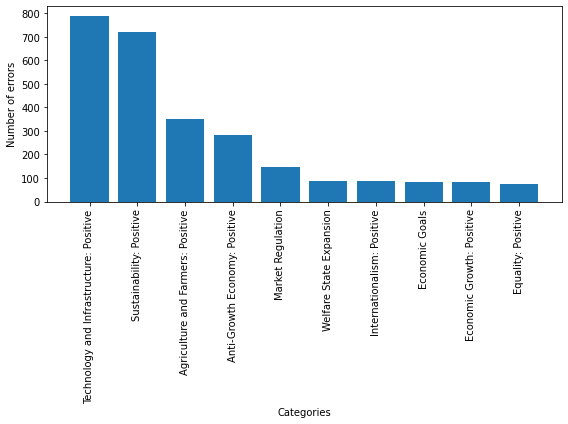

In [89]:
baseline_fp_dict= dict(sorted(baseline_fp_dict.items(), key=lambda item: item[1],reverse=True))
# Take the first 10 elements from the dictionary
data = dict(list(baseline_fp_dict.items())[:10])

# Extract the labels (keys) and values from the dictionary
labels = list(data.keys())
values = list(data.values())

# Create a bar graph with rotated x-axis labels
plt.figure(figsize=(8, 6))  # Set the figure size
plt.bar(labels, values)
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.xlabel('Categories')  # X-axis label
plt.ylabel('Number of errors')  # Y-axis label # Title of the graph
plt.tight_layout()  # Ensure the labels fit within the figure
plt.show()

In [98]:
for item in baseline_fn:
    for i in test_dataframe:
        if item['sentence']==i['sentence']:
            print("-------")
            print(i)
            print(item)

-------
{'sentence': ' Only if technologies, investments and projects in decarbonization ultimately prove to be economical will the transformation of the century succeed.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Only if technologies, investments and projects in decarbonization ultimately prove to be economical will the transformation of the century succeed.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' It is essential to have special benefit schemes for immature technologies', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' It is essential to have special benefit schemes for immature technologies', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'DOM filed criminal charges against them, which were rejected.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'DOM 

-------
{'sentence': ' A serious offensive by the Coast Guard aimed at limiting the speed of ships by imposing fines on offenders is necessary.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' A serious offensive by the Coast Guard aimed at limiting the speed of ships by imposing fines on offenders is necessary.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Target:', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Target:', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': " We create an additional opportunity for municipalities to support dental care according to people's income and needs.", 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': " We create an additional opportunity for municipalities to support dental care according to people's income and needs.", 'true_label'

-------
{'sentence': ' Others choose to leave the calf with the mother in the first 12 hours of life and few are those who leave the calf with the mother for 24 hours.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Others choose to leave the calf with the mother in the first 12 hours of life and few are those who leave the calf with the mother for 24 hours.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'The socialist epoch only took from it, as well as from other properties.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'The socialist epoch only took from it, as well as from other properties.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Value - 2 million. euros (through IPA financing - 85% IPA funds and 15% domestic participation).', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of

-------
{'sentence': ' It was the United Nations, through UNEP, which first took an in-depth interest in this subject in December 2007.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' It was the United Nations, through UNEP, which first took an in-depth interest in this subject in December 2007.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Austria must position itself clearly and unequivocally with regard to the new genetic engineering and oppose any relaxation of EU genetic engineering law.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Austria must position itself clearly and unequivocally with regard to the new genetic engineering and oppose any relaxation of EU genetic engineering law.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' We demand implementation of the pre-election commitments to strengthen the Environm

-------
{'sentence': ' Development of the legal framework', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Development of the legal framework', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Income from toll rings and road pricing must be used to improve transport, either for public transport investments or for environmentally improving road measures.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Income from toll rings and road pricing must be used to improve transport, either for public transport investments or for environmentally improving road measures.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'the Spanish Forestry Strategy', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'the Spanish Forestry Strategy', 'true_label': '1', 'predicted_label': '0'}
-------
{

-------
{'sentence': ' SV wants to develop a strategy where, through an interaction between the public and business sectors, research and development and the implementation of environmental measures are invested in, which can contribute to creating a technological edge.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' SV wants to develop a strategy where, through an interaction between the public and business sectors, research and development and the implementation of environmental measures are invested in, which can contribute to creating a technological edge.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Together with the network operators, we want to ensure that the network and supply security is guaranteed.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Together with the network operators, we want to ensure that the network and supply s

-------
{'sentence': ' . What we have today must be handed over to the next generation in better condition than when we took it over', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' . What we have today must be handed over to the next generation in better condition than when we took it over', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Social policy and social welfare', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Social policy and social welfare', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' — Stop very high voltage in Catalonia.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' — Stop very high voltage in Catalonia.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' 10.6 Protected territories - not only for the state, but also for the citize

-------
{'sentence': ' 12. Prohibit sports shit', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' 12. Prohibit sports shit', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Favor us an exercise of the fishing activity with sustainability criteria.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Favor us an exercise of the fishing activity with sustainability criteria.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' similar to the Illatos út problem solution.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' similar to the Illatos út problem solution.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Additional income from tank tourism should be used to finance the energy transition.', 'detailed_label': 'Environmental Protection', 'general_label': 'W

-------
{'sentence': ' La Hague and Marcoule will be converted to take part in disposal;', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' La Hague and Marcoule will be converted to take part in disposal;', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': " has the Alliance met the sport's desire for a stable and long-term funding system.", 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': " has the Alliance met the sport's desire for a stable and long-term funding system.", 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' . In addition, there is a large savings potential in the industry', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' . In addition, there is a large savings potential in the industry', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' The financ

-------
{'sentence': 'Further promotion of the organization of productive and technological activities (Industrial - Technological Parks), collective organization of modern exhibition spaces for the presentation of products and introduction of new systems of marketing and distribution of products (Commercial & Merchandise Parks etc.) or wider services of the tertiary sector (such as Business Parks, Parks of Services, Parks of Recreation and Entertainment - Tourist functions, Parks of Administration, etc.).', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'Further promotion of the organization of productive and technological activities (Industrial - Technological Parks), collective organization of modern exhibition spaces for the presentation of products and introduction of new systems of marketing and distribution of products (Commercial & Merchandise Parks etc.) or wider services of the tertiary sector (such as Business Parks

-------
{'sentence': ' Distribution network companies will be encouraged to install large-scale energy storage at their level.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Distribution network companies will be encouraged to install large-scale energy storage at their level.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Ethical standards in research', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Ethical standards in research', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' We do not consider that areas declared as such are governed by an integrated protection regime since the competent services are also weak and powerless due to the incomplete legal framework.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' We do not consider that areas declared as such ar

-------
{'sentence': "and increase the manufacturing industry's capacity to guarantee the absorption of these products.", 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': "and increase the manufacturing industry's capacity to guarantee the absorption of these products.", 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Urban development', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Urban development', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Considerable importance must be attached to fisheries interests.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Considerable importance must be attached to fisheries interests.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' If every driver installs this app, several thousand MWh per year are automatical

-------
{'sentence': ' pension', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' pension', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' No to the manipulation of living beings,', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' No to the manipulation of living beings,', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' — Decontamination of the Flix reservoir.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' — Decontamination of the Flix reservoir.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Thanks to our policy, that percentage has increased to 51 percent.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Thanks to our policy, that percentage has increased to 51 percent.', 'true_label':

-------
{'sentence': ' in close connection with taking advantage of the opportunities associated with the implementation of the new rural development policy;', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' in close connection with taking advantage of the opportunities associated with the implementation of the new rural development policy;', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' The Labor Party will insist on anchoring the principles of TAMA 35 in every development plan, and prioritizing the strengthening, densification and densification of existing settlements over the creation of new settlements or construction in open areas, recognizing the importance of strengthening the urban fabric', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The Labor Party will insist on anchoring the principles of TAMA 35 in every development plan, and prio

-------
{'sentence': ' We will promote the promotion of electric mobility from the Escrow Administration and within the Administration itself.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' We will promote the promotion of electric mobility from the Escrow Administration and within the Administration itself.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'We will establish a single notification and alarm system', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'We will establish a single notification and alarm system', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Healthy food:', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Healthy food:', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' F. Support research to promote the least painful piglet cast

-------
{'sentence': ' It is also necessary to ensure the active participation of Lithuanian representatives in international forums, negotiations and other formats that would allow for the creation of relations with specialists and policy makers of other countries.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' It is also necessary to ensure the active participation of Lithuanian representatives in international forums, negotiations and other formats that would allow for the creation of relations with specialists and policy makers of other countries.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' The global financial markets have the potential to become a key lever for more climate protection if there is corresponding demand for climate-friendly investments from investors and customers.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The g

-------
{'sentence': ' (1) Environmental indicators within the traditional gross national product (GNP) would represent the creation of economic growth through negative effects associated with high damage clean-up costs and would provide a completely different picture of our national economy.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' (1) Environmental indicators within the traditional gross national product (GNP) would represent the creation of economic growth through negative effects associated with high damage clean-up costs and would provide a completely different picture of our national economy.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' In the event of default by the person responsible for the pollution, he will be prosecuted and the land transferred to the public authorities;', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' In

-------
{'sentence': ' Aquaculture appears to be a way of the future.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Aquaculture appears to be a way of the future.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Tax reduction for expenses incurred to save energy in a home (since law of 10 August 2001).', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Tax reduction for expenses incurred to save energy in a home (since law of 10 August 2001).', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Cantonal, agglomeration and regional planning should closely coordinate settlement and mobility development and, in addition to qualitative and quantitative aspects, also include the energy relevance of developments.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Cantonal, agg

-------
{'sentence': ' We want an "Efficiency Strategy for SMEs" that aims to provide better information and low-interest loans and grants for energy efficiency measures.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' We want an "Efficiency Strategy for SMEs" that aims to provide better information and low-interest loans and grants for energy efficiency measures.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' . In the wake of the economic crisis, a number of companies will undergo major changes', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' . In the wake of the economic crisis, a number of companies will undergo major changes', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': " Cultural activities, cultural tourism, creative industries are fully developed, and the country's cultural heritage is properly protected.", 'detaile

-------
{'sentence': 'One of the priority issues is the initiation of activities on the use of biomass from our forests as well as the use of other forest products - forest, medicinal, honey-bearing and edible plants in order to expand production and employ unproductive labor.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'One of the priority issues is the initiation of activities on the use of biomass from our forests as well as the use of other forest products - forest, medicinal, honey-bearing and edible plants in order to expand production and employ unproductive labor.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' IV.4 INFRASTRUCTURE AND TRANSPORT POLICY', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' IV.4 INFRASTRUCTURE AND TRANSPORT POLICY', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' It is based on scientifical

-------
{'sentence': ' All projects such as Kanal Istanbul will be stopped even if they have been started.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' All projects such as Kanal Istanbul will be stopped even if they have been started.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' At the same time, we must invest in energy savings both in businesses, homes and publicly owned buildings.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' At the same time, we must invest in energy savings both in businesses, homes and publicly owned buildings.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'Oil and gas extraction is a dominant activity in Norway.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'Oil and gas extraction is a dominant activity in Norway.', 'true_label'

-------
{'sentence': ' The number of chronic diseases is increasing.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The number of chronic diseases is increasing.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' »< Haifa Bay', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' »< Haifa Bay', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' - Taking steps in line with the best international experiences, but replacing a lower contribution relative to other taxes (thus without increasing the tax burden)', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' - Taking steps in line with the best international experiences, but replacing a lower contribution relative to other taxes (thus without increasing the tax burden)', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentenc

-------
{'sentence': 'In turn, the sectoral plans should be valued as the seat of definition and concertation of sectoral projects with an impact on the territory.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'In turn, the sectoral plans should be valued as the seat of definition and concertation of sectoral projects with an impact on the territory.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' • Increased use of value creation potential of alternative drives/ e-mobility in Austria.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' • Increased use of value creation potential of alternative drives/ e-mobility in Austria.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'The process of exhausting the law has improved somewhat in recent years, but in too many cases it is almost non-existent.', 'detailed_label': 'Environmental P

-------
{'sentence': ' The export asset of the future', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The export asset of the future', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' • Enhancement of tourist resources and construction of quality offers.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' • Enhancement of tourist resources and construction of quality offers.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' There is no trend reversal in sight in 2019.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' There is no trend reversal in sight in 2019.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'Prevention and reduction of these infections and risks is a banner of the "Kulana" party, which was very active on the issue in the last term.', 'd

-------
{'sentence': ' The land that gives sustenance is a national wealth, without which life is unthinkable.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The land that gives sustenance is a national wealth, without which life is unthinkable.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Local freedom, local responsibility', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Local freedom, local responsibility', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Planned activities:', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Planned activities:', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Our 2030 plan indicates how we invest both in our children and young people, but also in our nature, environment and climate.', 'detailed_label': 'Envir

-------
{'sentence': ' The issue that politicians and scientists from the UN climate panel are drawing attention to can be serious.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The issue that politicians and scientists from the UN climate panel are drawing attention to can be serious.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' We will reserve these funds for two purposes.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' We will reserve these funds for two purposes.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' A large part of the goods are imported into the EU.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' A large part of the goods are imported into the EU.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'Only one treatment plant (i

-------
{'sentence': 'In particular, the issue of energy pricing for residential consumers should not be determined by markets but by societal priorities.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'In particular, the issue of energy pricing for residential consumers should not be determined by markets but by societal priorities.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' the Czech landscape is our common heritage.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' the Czech landscape is our common heritage.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' II.I.4.4. Fostering smart and sustainable cities', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' II.I.4.4. Fostering smart and sustainable cities', 'true_label': '1', 'predicted_label': '0'}
-------
{'sen

-------
{'sentence': ' • a systematic forwarding of information to recognized non-governmental organizations,', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' • a systematic forwarding of information to recognized non-governmental organizations,', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' • Social balance.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' • Social balance.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' 4.8 Quebec agriculture', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' 4.8 Quebec agriculture', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' We will increasingly provide landscape planning with financial and human resources.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'se

-------
{'sentence': ' and two thirds of it are used as settlement areas.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' and two thirds of it are used as settlement areas.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'We are committed to minimizing our dependency on foreign countries.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'We are committed to minimizing our dependency on foreign countries.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' It is within this general framework that EAJ-PNV will establish, on a day-to-day basis, its positions in relation to the various political initiatives that it proposes or are proposed by others.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' It is within this general framework that EAJ-PNV will establish, on a day-to-

-------
{'sentence': ' Project 71: Working for global peacekeeping', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Project 71: Working for global peacekeeping', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Such a fight will be done by an integrated system of research, customs, supervision, enforcement and information.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Such a fight will be done by an integrated system of research, customs, supervision, enforcement and information.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' strengthening agriculture', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' strengthening agriculture', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'It is necessary to support this type of action, since the defense of the 

-------
{'sentence': ' As a holistic, we quickly access all the data about our forests.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' As a holistic, we quickly access all the data about our forests.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Oil provides 96% of transport energy.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Oil provides 96% of transport energy.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' These situations multiply by 50 to 60 times the densities of Castilla y León, which in the province of Soria has 9.17 inhab/km2, or of Castilla-La Mancha, which in the province of Guadalajara has 11.92 inhab/km2.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' These situations multiply by 50 to 60 times the densities of Castilla y León, which in th

-------
{'sentence': ' With the decision of the federal and state governments to search for a suitable location with the greatest possible security with an open mind, a new process has now begun.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' With the decision of the federal and state governments to search for a suitable location with the greatest possible security with an open mind, a new process has now begun.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' We will apply greater rigor in administrative concessions for the use of maritime-terrestrial space, which will only have to be made in exceptional cases of general interest.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' We will apply greater rigor in administrative concessions for the use of maritime-terrestrial space, which will only have to be made in exceptional cases of general i

-------
{'sentence': ' TAUROMACHIE AND OTHER SIMILAR MANIFESTATIONS', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' TAUROMACHIE AND OTHER SIMILAR MANIFESTATIONS', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'The provisions of international agreements (such as the Basel Convention, etc.) are also applied in this sphere.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'The provisions of international agreements (such as the Basel Convention, etc.) are also applied in this sphere.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Deadline: 2012', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Deadline: 2012', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Citizen diplomacy', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and 

-------
{'sentence': 'We stand by the agreed coal compromise.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'We stand by the agreed coal compromise.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': " The Democratic Camp's plan to fight against religion in the education system", 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': " The Democratic Camp's plan to fight against religion in the education system", 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' oPerform the legalization of all buildings built up to December 31, 1994 (for areas subsequently reintegrated in 1995, i.e. 1998) "ex lege" without major costs, as this is the only realistic option for solving that problem.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' oPerform the legalization of all buildings built up 

-------
{'sentence': ' The right to food is a human right and must not fall victim to corporate profit maximization.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The right to food is a human right and must not fall victim to corporate profit maximization.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Tax reduction for passive houses.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Tax reduction for passive houses.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' For the future, significant resources are needed to improve the situation.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' For the future, significant resources are needed to improve the situation.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Prepare a study on the impacts of 

-------
{'sentence': ' For Finnish tourism, clean nature and well-maintained destinations are a competitive asset that must be cherished.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' For Finnish tourism, clean nature and well-maintained destinations are a competitive asset that must be cherished.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' We will create, within the structure of the Ministry of the Environment, a Center for Water Studies that integrates already existing units in the General State Administration and', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' We will create, within the structure of the Ministry of the Environment, a Center for Water Studies that integrates already existing units in the General State Administration and', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' . SV says no to a third runway 

-------
{'sentence': '-exemplary public buildings, with “factor 4” level renovation by 2030;', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': '-exemplary public buildings, with “factor 4” level renovation by 2030;', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Promoting quality Macedonian wine on foreign markets.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Promoting quality Macedonian wine on foreign markets.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' SYN suggests:', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' SYN suggests:', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' 40 percentage points must be achieved internally within the EU, on the condition that it takes place through a cost-effective distribution between EU member states.

-------
{'sentence': ' On February 9, 2006, the Walloon government decided on the first 15 sites to be rehabilitated.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' On February 9, 2006, the Walloon government decided on the first 15 sites to be rehabilitated.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' and introduce a scheme with business and nature funds where applicable.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' and introduce a scheme with business and nature funds where applicable.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' In our Sweden, tax funds are primarily used to promote cultural expressions whose purpose is to please, beautify and create community.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' In our Sweden, tax funds are primarily 

-------
{'sentence': ' 4.4 Improving public transit', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' 4.4 Improving public transit', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' 2.2.2.3 Sustainable food and agriculture policy, rich landscape', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' 2.2.2.3 Sustainable food and agriculture policy, rich landscape', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Therefore, bullfights, bullfighting clubs or bullfighting schools will not be financed or publicized.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Therefore, bullfights, bullfighting clubs or bullfighting schools will not be financed or publicized.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'We support a joint landscape care strategy (buildin

-------
{'sentence': ' 9.2 Quarrying Activities', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' 9.2 Quarrying Activities', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' The focus of taxation must be shifted away from the taxation of doing work and employment towards the taxation of activities that consume the environment.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The focus of taxation must be shifted away from the taxation of doing work and employment towards the taxation of activities that consume the environment.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' The results are summarized in the following table.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The results are summarized in the following table.', 'true_label': '1', 'predicted_label': '0'}
-

-------
{'sentence': ' Sustainable development must be a cornerstone of Norwegian value creation.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Sustainable development must be a cornerstone of Norwegian value creation.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' The "emancipated" city.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The "emancipated" city.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': " The earth's ecosystem is threatened by the market economy.", 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': " The earth's ecosystem is threatened by the market economy.", 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' 8 municipalities will be selected as pilot municipalities in the first phase of implementation.', 'detailed_label': 'Environ

-------
{'sentence': ' and whose goal will be to formulate requirements and measures that will lead to correction in the long term.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' and whose goal will be to formulate requirements and measures that will lead to correction in the long term.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' This is the case of :', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' This is the case of :', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' In the long term, it must be limited to areas where there is no alternative.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' In the long term, it must be limited to areas where there is no alternative.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' We will convene all soci

{'sentence': ' A decentralized settlement is a prerequisite for creating sustainable management of natural resources.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Young people in particular are often willing to switch to bicycles.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Young people in particular are often willing to switch to bicycles.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' These measures must be defined in a long-term and binding manner so that the economy and the population can adapt to them.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' These measures must be defined in a long-term and binding manner so that the economy and the population can adapt to them.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' In partnership with the social partners, to make all jobs greener.', 'deta

-------
{'sentence': ' Austrian requirement in the EU: compulsory insurance for nuclear power plants with a remaining term of more than 5 years.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Austrian requirement in the EU: compulsory insurance for nuclear power plants with a remaining term of more than 5 years.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' We want to eliminate existing weaknesses in the current trading system and create effective incentives so that climate-damaging greenhouse gases can be avoided.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' We want to eliminate existing weaknesses in the current trading system and create effective incentives so that climate-damaging greenhouse gases can be avoided.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' — Repeal of Bullfighting as cultural heritage.', 'det

-------
{'sentence': 'Implementation of the legislation providing for the payment of a fee for the use of frequencies by private channels.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'Implementation of the legislation providing for the payment of a fee for the use of frequencies by private channels.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Everyone can get involved for a better environment with the shopping basket - in the health food store and in the discounter.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Everyone can get involved for a better environment with the shopping basket - in the health food store and in the discounter.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' There is currently no Austrian quality mark law that regulates the permissible designations and clarifies how regional designations may

-------
{'sentence': ' On the other hand, a complex approach to the environment will bring economic benefits as well - above all, more economical use of resources.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' On the other hand, a complex approach to the environment will bring economic benefits as well - above all, more economical use of resources.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' In the capital, the number of asthmatics increased by 80% in six years after 1990,', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' In the capital, the number of asthmatics increased by 80% in six years after 1990,', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'In 2012, a number of renowned neuroexperts adopted the Cambridge Declaration on Consciousness (The Cambridge Declaration on Consciousness, 7 July 2012).', 'detailed_label':

-------
{'sentence': 'By realizing reasonable projects for the benefit of people, society and nature instead of “crazy projects”', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'By realizing reasonable projects for the benefit of people, society and nature instead of “crazy projects”', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Croatia has 30 gas wells.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Croatia has 30 gas wells.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Informed consumerism, garbage and solid waste:', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Informed consumerism, garbage and solid waste:', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' interaction with schools and universities in promoting information, with emphasis 

{'sentence': ' living conditions in homes and communities.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' The European Union has recently been involved in the implementation of this strategic document, through the European Cohesion Policy, which supports green economic growth.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The European Union has recently been involved in the implementation of this strategic document, through the European Cohesion Policy, which supports green economic growth.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' SV therefore wants to limit the scope of advertising.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' SV therefore wants to limit the scope of advertising.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' 2. NATURE, WATER, AGRICULTURE, FOOD, HEALTH, HOUSING AT THE HEA

-------
{'sentence': ' Then countries are needed that dare to show that a long-term sustainable world is not only possible - but also long-awaited.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Then countries are needed that dare to show that a long-term sustainable world is not only possible - but also long-awaited.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' We need to slow the growth of motoring.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' We need to slow the growth of motoring.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' During occasional measurements, the presence of heavy metals was determined in the areas next to metal processing industries.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' During occasional measurements, the presence of heav

-------
{'sentence': "We are aware of our responsibility to future generations to take care of Bulgaria's nature.", 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': "We are aware of our responsibility to future generations to take care of Bulgaria's nature.", 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Denmark must be a pioneering country in the circular economy', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Denmark must be a pioneering country in the circular economy', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' 1.2. TECHNOLOGICAL CAPITAL: INDUSTRIAL POLICY, RESEARCH AND THE INFORMATION SOCIETY.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' 1.2. TECHNOLOGICAL CAPITAL: INDUSTRIAL POLICY, RESEARCH AND THE INFORMATION SOCIETY.', 'true_label': '1', 'predicted_la

-------
{'sentence': ' Because the BDP has never launched an initiative for tactical reasons, but always pursues a solution-oriented policy, it has decided not to launch an initiative of its own.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Because the BDP has never launched an initiative for tactical reasons, but always pursues a solution-oriented policy, it has decided not to launch an initiative of its own.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'Existing laws and regulations must be applied consistently and compliance with them must be monitored more strictly than before.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'Existing laws and regulations must be applied consistently and compliance with them must be monitored more strictly than before.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Deadline: 2 0 1 4

{'sentence': ' The wind power sector', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'In particular, it should be made the task of professional public bodies to help and motivate their members for such activities,', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'In particular, it should be made the task of professional public bodies to help and motivate their members for such activities,', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': '1.4. Activity restrictions set in protected and other territories must be based on the public interest and not create unjustified difficulties for local residents and businesses.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': '1.4. Activity restrictions set in protected and other territories must be based on the public interest and not create unjustified difficulties for local residents and busines

-------
{'sentence': 'Expand and internationalize the natural.pt brand, of products and services developed based on the resources of protected areas, reaching, in 2016, 200 adherents (products and services) and increasing an average annual rate of 10% from 2017 to 2030.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'Expand and internationalize the natural.pt brand, of products and services developed based on the resources of protected areas, reaching, in 2016, 200 adherents (products and services) and increasing an average annual rate of 10% from 2017 to 2030.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' which ensures the life and health of the population of Georgia,', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' which ensures the life and health of the population of Georgia,', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence

-------
{'sentence': ' In this context, the Socialists propose a national inventory in the field of cultural animation.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' In this context, the Socialists propose a national inventory in the field of cultural animation.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' The demand for sustainability is not an obstacle for the economy, but a real opportunity for innovative, future-oriented companies.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The demand for sustainability is not an obstacle for the economy, but a real opportunity for innovative, future-oriented companies.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'The Republic of Macedonia, more than ever, needs sustainable development, which will offer a different way of acting and thinking than the existing one,', 'detail

-------
{'sentence': 'LIBERAL SOCIAL POLICY', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'LIBERAL SOCIAL POLICY', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' - not least for the sake of future generations.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' - not least for the sake of future generations.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' At the beginning of the 21st century, we finally have the chance to initiate such an energy turnaround and free ourselves from this dependency, which is also fatal for the climate.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' At the beginning of the 21st century, we finally have the chance to initiate such an energy turnaround and free ourselves from this dependency, which is also fatal for the climate.', 'true_

-------
{'sentence': ' Educational institutions will function as energy-efficient buildings,', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Educational institutions will function as energy-efficient buildings,', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'XII MORE OPEN, SIMPLE AND EFFICIENT GOVERNANCE45', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'XII MORE OPEN, SIMPLE AND EFFICIENT GOVERNANCE45', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Circular economy and resource efficiency:', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Circular economy and resource efficiency:', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'It is also a field for targeted employment of Greek scientists and creation of surplus value (research on environmentally

-------
{'sentence': ' The transport system must be reorganized in the direction of greater representation of public transport,', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The transport system must be reorganized in the direction of greater representation of public transport,', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'Budget: 20 million denars from a budget of Rs. Macedonia.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'Budget: 20 million denars from a budget of Rs. Macedonia.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'According to the performed analyses, Macedonia will need about one billion euros to align the energy plants with the undertaken obligations towards the European regulations (desulfurization, removal of PM 10 and PM 2.5 dust particles, etc.).', 'detailed_label': 'Environmental Protection', 'gener

-------
{'sentence': ' An extremely uniform model that puts an end to the social diversity that is the city by definition.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' An extremely uniform model that puts an end to the social diversity that is the city by definition.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' The organized implementation of this program significantly improves the livable situation in Hungary.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The organized implementation of this program significantly improves the livable situation in Hungary.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': 'We will seek agreement with provincial, regional, municipal, Indigenous and community stakeholders to create a National Conservation Plan to:', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare 

-------
{'sentence': 'The economy should strive for an equal quality of life, today, but also in the future.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': 'The economy should strive for an equal quality of life, today, but also in the future.', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' Agriculture, xpans, fisheries, forests', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' Agriculture, xpans, fisheries, forests', 'true_label': '1', 'predicted_label': '0'}
-------
{'sentence': ' The subject of the effect of magnetic fields on human health concerns citizens all over the world due to its connection with various diseases.', 'detailed_label': 'Environmental Protection', 'general_label': 'Welfare and Quality of Life'}
{'sentence': ' The subject of the effect of magnetic fields on human health concerns citizens all over the world due to its connec

# The error analysis of the model trained on Manifesto dataset and tested on Claims dataset

In [12]:
errors_claimsDataset_tested,original_claims= find_wrong_predictions("Tested_claims_trained_manifesto.txt")

General number of all sentences: 2647
Number of wrongly predicted sentences: 620


In [13]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from transformers.pipelines.pt_utils import KeyDataset
import datasets
from tqdm.auto import tqdm

dataset_name = "climatebert/environmental_claims"
# If you want to use your own data, simply load them as 🤗 Datasets dataset, see https://huggingface.co/docs/datasets/loading
climatebert = datasets.load_dataset(dataset_name)
climatebert_dataset=[]
for k,v in climatebert.items():
    for sentence in v:
        climatebert_dataset.append(sentence)
        
def find_repeated_sentences(data_frame):
    sentence_counts = {}
    
    # Count the occurrences of each sentence
    for item in data_frame:
        sentence = item["text"]
        if sentence not in sentence_counts:
            sentence_counts[sentence] = 0
        sentence_counts[sentence] += 1
    
    repeated_sentences = [sentence for sentence, count in sentence_counts.items() if count > 1]
    print("The number of repeated sentences:", len(repeated_sentences))
    
    repeated_sentence_items = {}
    
    # Collect items with repeated sentences
    for item in data_frame:
        sentence = item["text"]
        if sentence in repeated_sentences:
            if sentence not in repeated_sentence_items:
                repeated_sentence_items[sentence] = []
            repeated_sentence_items[sentence].append(item)
    
    return repeated_sentence_items

# Usage example:
# Assuming you have a 'test_dataframe' with the same structure as before
check_repeated_sentences = find_repeated_sentences(climatebert_dataset)

The number of repeated sentences: 0


In [14]:
def count_false_positives_and_negatives(data):
    """
    Count false positives (FP) and false negatives (FN) from a list of dictionaries.
    
    Returns:
    fp_count (int): Number of false positives.
    fn_count (int): Number of false negatives.
    """
    fp_count = []
    fn_count = []
    
    for example in data:
        
        true_label = int(example['true_label'])
        predicted_label = int(example['predicted_label'])
        
        if true_label == 1 and predicted_label == 0:
            fn_count.append(example)
        elif true_label == 0 and predicted_label == 1:
            fp_count.append(example)
    fp_percent=round((len(fp_count)/len(data))*100)
    fn_percent=round((len(fn_count)/len(data))*100)
    print("The number of fasle positives:",len(fn_count),",and percentage of it:",fp_percent,"%")
    print("The number of false negatives:",len(fp_count),",and percentage of it:",fn_percent,"%")
    return fp_count, fn_count

In [15]:
claims_fp,claims_fn=count_false_positives_and_negatives(errors_claimsDataset_tested)

The number of fasle positives: 155 ,and percentage of it: 75 %
The number of false negatives: 465 ,and percentage of it: 25 %


In [16]:
claims_fp

[{'sentence': 'In this way, it offers all occupants a more comfortable and less tiring ride and enables them to respond quickly to environmental changes.',
  'true_label': '0',
  'predicted_label': '1'},
 {'sentence': "As an example, our VOC products, we're starting that unit up and have very strong expectations that, that unit will fill very rapidly, as Chinese consumers are after environmental quality and health impacts that come with low VOC products.",
  'true_label': '0',
  'predicted_label': '1'},
 {'sentence': "So we've had a primary focus on helping the OEMs meet their fuel economy/CO2 emissions requirements.",
  'true_label': '0',
  'predicted_label': '1'},
 {'sentence': "Interesting side note, okay, as of today, I'm not saying that's -- that, that we can make this comment in a year from now because I don't know, but we have dropped off our carbon steel processing operations either.",
  'true_label': '0',
  'predicted_label': '1'},
 {'sentence': 'Ongoing socio-economic and env

In [97]:
claims_fn

[{'sentence': 'The initiatives combine investments with policy dialogue and technical assistance in a highly coordinated manner to increase economic resilience, foster integration and address common global and regional challenges such as climate change.',
  'true_label': '1',
  'predicted_label': '0'},
 {'sentence': 'Environmentally and socially responsible supply chains – Sustainability To meet these challenges, Kering has established a dedicated organization.',
  'true_label': '1',
  'predicted_label': '0'},
 {'sentence': 'The average electricity consumption per server operated by the Transformation and Operational Efficiency Department was halved between December 2013 and December 2017 from 0.427kWh/server to 0.214kWh/server.',
  'true_label': '1',
  'predicted_label': '0'},
 {'sentence': 'In September 2020, BBVA, together with other financial institutions, published a joint methodology to align its credit portfolios with the objectives of the Paris Agreement on climate change.',
  

# Inverse: error analysis of the model trained on Claims dataset and tested on Manifesto dataset


In [19]:
errors_ManifestoDataset_tested_trained_Claims,original_manifesto_claims= find_wrong_predictions("Test_manifesto_train_Claims_right.txt") 

General number of all sentences: 84860
Number of wrongly predicted sentences: 7647


In [47]:
baseline_errors = [item['sentence'] for item in errors_baseline]
claims_baseline_erorrs=[item['sentence'] for item in errors_ManifestoDataset_tested_trained_Claims]

In [49]:
common_mistakes=set(baseline_errors).intersection(set(claims_baseline_erorrs))
print(len(common_mistakes))

3309


In [99]:
count=0
common_fp_mistakes={}
for s in common_mistakes:
    for item in errors_ManifestoDataset_tested_trained_Claims:
        if s==item["sentence"]:
            if item['true_label']=="0":
                count+=1
                for element in test_dataframe:
                    if element['sentence']==s:
                        if element['detailed_label'] not in common_fp_mistakes:
                            common_fp_mistakes[element['detailed_label']]=0
                        common_fp_mistakes[element['detailed_label']]+=1

In [102]:
count

1414

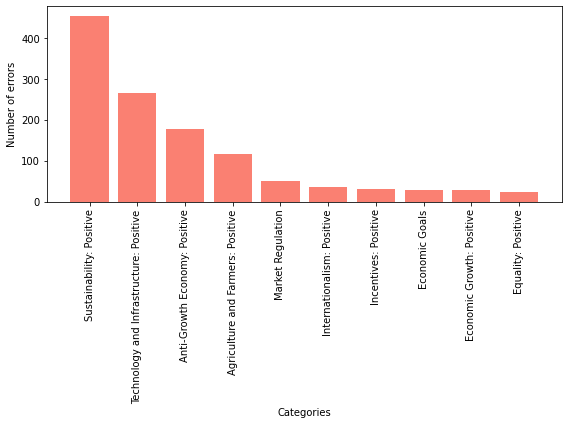

In [105]:
common_fp_mistakes= dict(sorted(common_fp_mistakes.items(), key=lambda item: item[1],reverse=True))
# Take the first 10 elements from the dictionary
data = dict(list(common_fp_mistakes.items())[:10])

# Extract the labels (keys) and values from the dictionary
labels = list(data.keys())
values = list(data.values())

# Create a bar graph with rotated x-axis labels
plt.figure(figsize=(8, 6))  # Set the figure size
plt.bar(labels, values,color='salmon')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.xlabel('Categories')  # X-axis label
plt.ylabel('Number of errors')  # Y-axis label # Title of the graph
plt.tight_layout()  # Ensure the labels fit within the figure
plt.show()

# The error analysis of the model trained on Manifesto dataset and tested on 10KS dataset

In [4]:
errors_10ks_tested = find_wrong_predictions("Test_10ks_train_mainfesto.txt")

General number of all sentences: 3300
Number of wrongly predicted sentences: 244


# Inverse: error analysis of the model trained on 10KS dataset and tested on Manifesto dataset

In [8]:
errors_ManifestoDataset_tested_trained_10ks = find_wrong_predictions("Test_manifesto_train_10ks_right.txt")

General number of all sentences: 84860
Number of wrongly predicted sentences: 7475


# Intersection of errors: Baseline  and Claims dataset

In [24]:
print("The number of unique baseline model errors:",len(set(baseline_erros)))
print("The number of unique claims dataset model erros:",len(set(manifesto_claim)))
common_sentences=set(baseline_erros).intersection(set(manifesto_claim))
print("How many sentences do they have in common:",len(common_sentences))

The number of unique baseline model errors: 5580
The number of unique claims dataset model erros: 7641
How many sentences do they have in common: 3309
